In [1]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

/home/salo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/salo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/salo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/salo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

### Paths

In [2]:
#File paths
main_path_energy ='../data_base/paths_energy/'
main_path_total_energy = '../data_base/paths_totals/'

energy_path11_pd = pd.read_csv(main_path_energy + 'feat_pathv11.csv')
energy_path12_pd = pd.read_csv(main_path_energy + 'feat_pathv12-2.csv')
energy_path13_pd = pd.read_csv(main_path_energy + 'feat_pathv13.csv')

energy_path_list = [energy_path11_pd,energy_path12_pd,energy_path13_pd]
complete_energy_pd = pd.concat(energy_path_list)

total_path11_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv11.csv')
total_path12_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv12-2.csv')
total_path13_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv13.csv')

total_path_list = [total_path11_pd,total_path12_pd,total_path13_pd]
complete_total_pd = pd.concat(total_path_list)

### Data split and preprocessing - complete_energy_pd - All data

this data comes from the folder "paths_energy"

In [3]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()

X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (2486, 622)


### Model - Neural network - relu and linear

In [4]:
NN_model = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model.add(Dense(64,kernel_initializer=ran_initial,input_dim=7,activation='relu'))

NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Tota

In [5]:
start_time = time.time()
model1 = NN_model.fit(x_train, y_train, epochs=300, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Execution time = 32.41562819480896


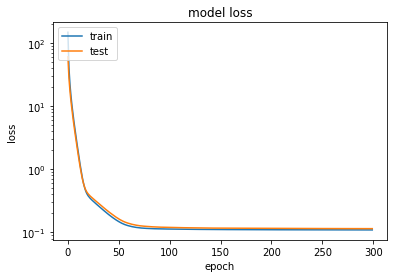

In [6]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
y_predict = NN_model.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.6444222675937177
RMSE: 1140831.1692788298
MSE: 1301495756798.1023


### Data split and preprocessing - complete_energy_pd - with eps

In [8]:
eps = 5
complete_energy_pd = complete_energy_pd[(complete_energy_pd['sim_point_dist']-complete_energy_pd['teo_point_dist']) < eps]
print(f'new shape of complete_energy_pd = {complete_energy_pd.shape}')

new shape of complete_energy_pd = (2577, 16)


In [9]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()
x2 = X
X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler2 = StandardScaler()

x_train = scaler2.fit_transform(x_train)
x_test = scaler2.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (2061, 516)


In [10]:
NN_model11 = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model11.add(Dense(64,kernel_initializer=ran_initial,input_dim=7,activation='relu'))

NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model11.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model11.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.2), metrics=["mean_squared_logarithmic_error"])

In [11]:
start_time = time.time()
model11 = NN_model11.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


Execution time = 8.031324863433838


In [12]:
y_predict = NN_model11.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.7336018367321469
RMSE: 738936.7532377022
MSE: 546027525285.47675


In [13]:
def is_outlier(points, thresh=15):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

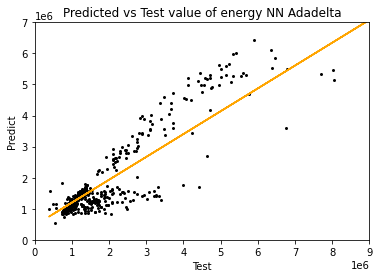

In [14]:
filter_predict = y_predict[~is_outlier(y_test)]
filter_test = y_test[~is_outlier(y_test)]

plt.scatter(y_test, y_predict,linewidths=0.01,c='black',marker='.')
plt.xlabel('Test')
plt.ylabel('Predict')
m, b = np.polyfit(y_test, y_predict, 1)

#plt.scatter(filter_test, filter_predict,linewidths=0.01, marker='.')
plt.plot(y_test, m*y_test + b, color='orange')
plt.title('Predicted vs Test value of energy NN Adadelta')
plt.xlabel('Test')
plt.ylabel('Predict')
plt.xlim([0, 0.9e7])
plt.ylim([0, 0.7e7])
plt.savefig('predictvtest_NN_Adadelta.png')

In [17]:
weights = NN_model11.layers[5].get_weights()[0]
biases = NN_model11.layers[5].get_weights()[1]
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(NN_model11, random_state=1).fit(x2,y)
# eli5.show_weights(perm, feature_names = x2.columns.tolist())


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fab30688d30> does not.

In [ ]:
plt.plot(model11.history['loss'])
plt.plot(model11.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model - Neural network - sigmoid and linear

In [ ]:
NN_model2 = Sequential()

NN_model2.add(Dense(128,kernel_initializer='normal',input_dim=7,activation='sigmoid'))

NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))

NN_model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model2.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model2.summary()

In [ ]:
start_time = time.time()
model2 = NN_model2.fit(x_train, y_train, epochs=350, batch_size=32, validation_split = 0.2,verbose=0)
print('Execution time = ' + str(time.time() - start_time))


In [ ]:
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_predict = NN_model2.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')